In [8]:
import zipfile
import json
import io
import os

In [9]:
def read_json_from_folder(folder_path):
    data = {}
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        with open(file_path, 'r', encoding='utf-8') as f:
            data[json_file] = json.load(f)
    
    return data


In [10]:
dataset_path = "/kaggle/input/ama-sum/min_10_max_100_revs_filt_complete"

train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")


In [11]:
train_data = read_json_from_folder(train_path)
test_data = read_json_from_folder(test_path)
valid_data = read_json_from_folder(valid_path)

# Print a sample JSON file
sample_file = list(train_data.keys())[0]
print(f"Sample file: {sample_file}\nData:\n", train_data[sample_file])

Sample file: B00LBFFSNM.json
Data:
 {'website_summaries': [{'verdict': "With its fun design and cheap price, the Lumia 635 is a decent option to consider if you're after 4G LTE on a budget. It's only marginally more expensive than its near-identical 3G-only Lumia 630 sibling, so you should certainly opt for the 635. If you want a better selection of apps however, the Motorola Moto G is still the 4G phone to go for.", 'pros': ['The Nokia Lumia 635 has an affordable price, its interchangeable cases are colourful and attractive and it has 4G LTE'], 'cons': ["Adding 4G LTE has meant the battery life has taken a hit, its screen resolution is unimpressive and its camera isn't really up to anything more than the odd Instagram snap"], 'aspects': {'Design': 7.0, 'Features': 7.0, 'Performance': 5.0}, 'publication_date': 20140807, 'rating': 7.5, 'source': 'cnet'}], 'customer_reviews': [{'title': 'this is the absolute best phone for the money in my opinion', 'text': 'As long as this is still avail

In [12]:
import os
import json
import pandas as pd
from tqdm import tqdm

def prepare_dataset(folder_path):
    """Reads JSON files and prepares data for summarization, including pros and cons."""
    data_list = []
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    for json_file in tqdm(json_files, desc=f"Processing {folder_path}"):
        file_path = os.path.join(folder_path, json_file)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

            # Extract all customer reviews
            reviews = []
            if "customer_reviews" in data:
                for review in data["customer_reviews"]:
                    reviews.append(review.get("text", ""))

            # Extract summary, pros, and cons
            if "website_summaries" in data:
                summary_data = data["website_summaries"][0]  # First summary
                summary = summary_data.get("verdict", "")
                pros = ", ".join(summary_data.get("pros", []))  # Convert list to string
                cons = ", ".join(summary_data.get("cons", []))  # Convert list to string

                if reviews and summary:
                    combined_reviews = " ".join(reviews)  # Merge all reviews
                    data_list.append({
                        "reviews": combined_reviews,
                        "pros": pros,
                        "cons": cons,
                        "summary": summary
                    })

    return pd.DataFrame(data_list)

# Define dataset paths
dataset_path = "/kaggle/input/ama-sum/min_10_max_100_revs_filt_complete"

# Prepare Train, Validation, and Test Data
train_df = prepare_dataset(os.path.join(dataset_path, "train"))
valid_df = prepare_dataset(os.path.join(dataset_path, "valid"))
test_df = prepare_dataset(os.path.join(dataset_path, "test"))

# Save to CSV for later use
train_df.to_csv("t5_train_data.csv", index=False)
valid_df.to_csv("t5_valid_data.csv", index=False)
test_df.to_csv("t5_test_data.csv", index=False)




Processing /kaggle/input/ama-sum/min_10_max_100_revs_filt_complete/train: 100%|██████████| 25203/25203 [00:37<00:00, 668.36it/s]
Processing /kaggle/input/ama-sum/min_10_max_100_revs_filt_complete/valid: 100%|██████████| 3114/3114 [00:04<00:00, 635.59it/s]
Processing /kaggle/input/ama-sum/min_10_max_100_revs_filt_complete/test: 100%|██████████| 3166/3166 [00:04<00:00, 652.05it/s]


In [7]:
# Display sample
print("Train Data Sample:")
print(train_df['reviews'][0])
print("\nValidation Data Sample:")
print(valid_df['summary'][0])
print("\nTest Data Sample:")
print(test_df['pros'][0])
print(test_df['cons'][0])

Train Data Sample:
As long as this is still available, this is the absolute best phone for the money in my opinion. I researched seemingly forever for a low priced full-featured phone, and this fits the bill. The Windows O.S. is seamless and easy to customize and navigate. I just bought two more for my wife and daughter, who were always "borrowing" mine. I just have to chuckle when I see everyone swooning over the latest exhorbitantly priced Apple phones, and paying the equvalent of a car payment to do the same things this phone does. And my $30/ month plan is adequate for my business calling, email checking and file sending needs, which is all I need it for. Effective July 31 2017 Microsoft no longer supports software on this phone. It took two hours at At&t to get contacts from old phone to this one. Only buy if you have a way to transfer your contacts and are a very knowledgeable Windows user. Design is poor as edges of screen are widest part of phone and not Gorilla glass, so any d

In [ ]:
import pandas as pd
a = pd.read_csv("t5_train_data.csv")


In [9]:
a.shape

(25203, 4)

In [13]:
import pandas as pd
from datasets import Dataset
from transformers import T5Tokenizer
from tqdm import tqdm

# Load CSV data with controlled size
def load_data(file_path, num_samples):
    df = pd.read_csv(file_path)
    df = df.sample(n=num_samples, random_state=42).reset_index(drop=True)  # Shuffle and take subset
    df["input_text"] = "summarize: " + df["reviews"]  # T5 requires a task-specific prefix
    df["target_text"] = df["pros"] +'. '+ df["cons"]
    return Dataset.from_pandas(df)

# Load dataset paths
train_path = "t5_train_data.csv"
valid_path = "t5_valid_data.csv"
test_path = "t5_test_data.csv"

# Load specific number of samples
train_dataset = load_data(train_path, 10000)
valid_dataset = load_data(valid_path, 2500)
test_dataset = load_data(test_path, 1000)

# Load T5 tokenizer
model_name = "t5-base"  # Change to t5-small, t5-large if needed
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"], padding="max_length", truncation=True, max_length=512, return_tensors="pt"
    )
    labels = tokenizer(
        examples["target_text"], padding="max_length", truncation=True, max_length=256, return_tensors="pt"
    )["input_ids"]
    model_inputs["labels"] = labels
    return model_inputs

# Tokenizing datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Save tokenized datasets to disk
train_dataset.save_to_disk("tokenized_train_dataset")
valid_dataset.save_to_disk("tokenized_valid_dataset")
test_dataset.save_to_disk("tokenized_test_dataset")

# Print first sample to verify
print(train_dataset[0])


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

{'reviews': 'If you have to deal with numbers, you need this pad for your laptop. Simple to use, just plug it into your usb port and go. I take the time to review purchases because I know that I rely on them myself and I like to try to help others make informed decisions. If my review was helpful to you, please click the "Helpful" button. Descent external 9 key keyboard, however it does not have a "delete" button (don\'t get fooled by the "Back Space" button) which is why I really wanted the external keypad. It is a little thicker than expected. I returned it because it didn\'t have a delete button. This keypad replaced a Belkin wireless keypad, which required a battery. I found that the battery was usually "dead" when I wanted to use it because it would turn on when a key was pressed. This was handy when preparing to use it, but a problem when traveling with it in a suitcase! The Satechi keypad plugs into my computer, so there\'ll be no problem with dead batteries. I\'ve only used it 

In [5]:
from datasets import load_from_disk
test_dataset = load_from_disk("tokenized_train_dataset")
print(test_dataset['target_text'][0])

Boasts easy set up via 36-inch USB cord, allowing users to use this 18-key device, Has handy bottom switch to indicate use with a “PC” or “Mac.” Works with myriad of operating systems. May be taller than your standard Mac keyboard, No equal or clear keys


In [71]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is detected
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the GPU
print(torch.cuda.memory_allocated() / 1024**3, "GB Allocated")  # Memory used
print(torch.cuda.memory_reserved() / 1024**3, "GB Reserved")  # Memory reserved


True
2
Tesla T4
13.42937183380127 GB Allocated
14.13671875 GB Reserved


In [69]:
import torch
torch.cuda.empty_cache()


In [70]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [6]:
pip install transformers datasets torch tqdm


Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
from transformers import T5ForConditionalGeneration, AdamW, get_scheduler
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm import tqdm

# Load tokenized datasets
train_dataset = load_from_disk("tokenized_train_dataset")
valid_dataset = load_from_disk("tokenized_valid_dataset")

# Convert datasets to PyTorch format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Convert to DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

# Load T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_dataloader) * 5  # 5 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Move model to device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize variables to track best model
best_valid_loss = float("inf")  # Start with very high loss
best_model_path = "best_t5pc_model"  # Directory to save the best model

# Training loop
for epoch in range(5):  # Train for 5 epochs
    model.train()
    train_loss = 0
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc="Validating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            valid_loss += outputs.loss.item()

    avg_valid_loss = valid_loss / len(valid_dataloader)
    print(f"Epoch {epoch+1} Validation Loss: {avg_valid_loss:.4f}")

    # Save the best model if validation loss improves
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        model.save_pretrained(best_model_path)
        print(f"New Best Model Saved at {best_model_path} (Validation Loss: {best_valid_loss:.4f})")

print("Training complete!")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2500/2500 [35:46<00:00,  1.16it/s, loss=0.976]


Epoch 1 Train Loss: 1.0100


Validating: 100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Epoch 1 Validation Loss: 0.8685
New Best Model Saved at best_t5pc_model (Validation Loss: 0.8685)


Epoch 2: 100%|██████████| 2500/2500 [35:44<00:00,  1.17it/s, loss=1.15] 


Epoch 2 Train Loss: 0.9000


Validating: 100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Epoch 2 Validation Loss: 0.8499
New Best Model Saved at best_t5pc_model (Validation Loss: 0.8499)


Epoch 3: 100%|██████████| 2500/2500 [35:46<00:00,  1.16it/s, loss=0.794]


Epoch 3 Train Loss: 0.8704


Validating: 100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Epoch 3 Validation Loss: 0.8416
New Best Model Saved at best_t5pc_model (Validation Loss: 0.8416)


Epoch 4: 100%|██████████| 2500/2500 [35:45<00:00,  1.17it/s, loss=0.851]


Epoch 4 Train Loss: 0.8514


Validating: 100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Epoch 4 Validation Loss: 0.8384
New Best Model Saved at best_t5pc_model (Validation Loss: 0.8384)


Epoch 5: 100%|██████████| 2500/2500 [35:46<00:00,  1.16it/s, loss=0.859]


Epoch 5 Train Loss: 0.8400


Validating: 100%|██████████| 625/625 [03:04<00:00,  3.39it/s]


Epoch 5 Validation Loss: 0.8374
New Best Model Saved at best_t5pc_model (Validation Loss: 0.8374)
Training complete!


In [15]:
model.save_pretrained("best_t5pc_model")
tokenizer.save_pretrained("best_t5pc_model")


('best_t5pc_model/tokenizer_config.json',
 'best_t5pc_model/special_tokens_map.json',
 'best_t5pc_model/spiece.model',
 'best_t5pc_model/added_tokens.json')

In [16]:
import shutil

# Zip the model directory
shutil.make_archive("best_t5pc_model", 'zip', "best_t5pc_model")


'/kaggle/working/best_t5pc_model.zip'

In [17]:
from IPython.display import FileLink

FileLink(r'best_t5pc_model.zip')



/kaggle/working/best_t5pc_model.zip

In [18]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_from_disk

# Load fine-tuned model and tokenizer
model_path = "/kaggle/working/best_t5pc_model"
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Load tokenized test dataset
test_dataset = load_from_disk("tokenized_test_dataset")

# Convert to PyTorch format
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [19]:
print(test_dataset['target_text'][0])

Well-made locks, Work well on zippers and small lockers, Company is responsive if you have problems with the locks, Locks come in orange or black. Setting the combination can be a little difficult, Some people have a hard time reopening their locks


In [20]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=504a2a3d184f1b8a792f167679204522071d0cdc7a007876d0b4e0d429f54767
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [21]:
from tqdm import tqdm

# Function to generate summaries
def generate_summary(sample, max_length=150, num_beams=5):
    input_ids = sample["input_ids"].unsqueeze(0).to(device)  # Add batch dimension
    attention_mask = sample["attention_mask"].unsqueeze(0).to(device)

    summary_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_beams=num_beams
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# Generate summaries for test dataset
generated_summaries = []
reference_summaries = []

for i in tqdm(range(len(test_dataset)), desc="Testing"):
    sample = test_dataset[i]  # Already tokenized input
    generated_summary = generate_summary(sample)  # No need for [0] since function returns string
    reference_summary = tokenizer.decode(sample["labels"], skip_special_tokens=True)

    #print(f"\nGenerated: {generated_summary}")
    #print(f"Reference: {reference_summary}")


print("Testing complete!")


Testing: 100%|██████████| 1000/1000 [35:49<00:00,  2.15s/it]

Testing complete!


In [25]:
print(test_dataset['target_text'][0])
print(generated_summary)

Well-made locks, Work well on zippers and small lockers, Company is responsive if you have problems with the locks, Locks come in orange or black. Setting the combination can be a little difficult, Some people have a hard time reopening their locks
Comes in a variety of colors and styles, Easy to set your own combination, Comes in a variety of sizes and colors, Comes in a variety of sizes and colors. This lock is not TSA approved, so it may not be suitable for all travelers


In [28]:
test_dataset[0]

{'input_ids': tensor([21603,    10,  2926,    29,    15,    26,    12,   653,   169,    34,
            44,     8,   422,  7868, 17596,  4981,     5, 14240,    27,  5285,
            34,   166,    16,    82,   609,    44,   234,     6,   274, 21097,
            95,    82,  4954,    11,  3435,     7,  1636,     8,  6081,   410,
            59,     3,    60,  8751, 12887,    94,    31,     7,   230, 16225,
         13249,     6,    11,   405,    59,   539,   893,    28,  6078,    42,
            28,    82,   293,  1081,     5,     3, 14116,   182,  2451,     5,
          1142,  7122,    16,    44,     8,  3761,    11,   530,     3,     9,
           580,    24,   332,  4507,   228,    59,   539, 15566,    18,    18,
           141,    12,   428,   135,     8, 15122,   147,     8,   951,     6,
           966,   141,    12,   281,    66,     8,   194,   223,    12,     8,
           691,    16,    11,   258,   190,  1034,   541,     5,  4486,     3,
             9,   207,   194,    12,   

In [29]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Store scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Evaluation loop
for i in tqdm(range(len(test_dataset)), desc="Evaluating ROUGE"):
    sample = test_dataset[i]
    
    # Generate summary
    generated_summary = generate_summary(sample)  
    reference_summary = tokenizer.decode(sample["labels"], skip_special_tokens=True)

    # Compute ROUGE scores
    scores = scorer.score(reference_summary, generated_summary)

    rouge1_scores.append(scores["rouge1"].fmeasure)
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)

# Compute average scores
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

# Print final results
print("\n💡 ROUGE Evaluation Results:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


Evaluating ROUGE: 100%|██████████| 1000/1000 [35:49<00:00,  2.15s/it]


💡 ROUGE Evaluation Results:
ROUGE-1: 0.1944
ROUGE-2: 0.0283
ROUGE-L: 0.1332


In [31]:
mooc_df = pd.read_csv("/kaggle/input/mooc-dataset/mooc_coursera_dataset.csv")

In [32]:
mooc_df.shape

(45096, 6)

In [33]:
mooc_df = mooc_df.drop_duplicates()

In [34]:
mooc_df = mooc_df.dropna(subset=["reviews"])

In [35]:
mooc_df.shape

(17417, 6)

In [36]:
course_reviews_dict = mooc_df.groupby("course_title")["reviews"].apply(list).to_dict()
for key,value in course_reviews_dict.items():
  print(key,len(value))

Agile with Atlassian Jira 807
Become a CBRS Certified Professional Installer by Google 51
Building Scalable Java Microservices with Spring Boot and Spring Cloud 206
Business Metrics for Data-Driven Companies 273
Data Analysis with Python 1474
Data Science Methodology 1182
Databases and SQL for Data Science 587
Fundamentals of Project Planning and Management 1160
Google Cloud Platform Big Data and Machine Learning Fundamentals 397
Introduction to Data Science in Python 5052
Introduction to User Experience Design 889
Natural Language Processing in TensorFlow 707
Operating Systems and You: Becoming a Power User 2631
Programming Foundations with JavaScript, HTML and CSS 573
Site Reliability Engineering: Measuring and Managing Reliability 163
Supply Chain Principles 351
The Social Context of Mental Health and Illness 92
Visual Elements of User Interface Design 822


In [37]:
print(course_reviews_dict['Become a CBRS Certified Professional Installer by Google'])

["Pretty dry, but I was able to pass with just two complete watches so I'm happy about that. As usual there were some questions on the final exam that were NO WHERE in the course, which is annoying but far better than many microsoft tests I have taken. Never found the suplimental material that the course references... but who cares... i passed!", 'would be a better experience if the video and screen shots would sho on the side of the text that the instructor is going thru so that user does not have to go all the way to beginning of text to be able to view any slides instructor is showing.', 'Information was perfect! The program itself was a little annoying. I had to wait 30 to 45 minutes after watching the videos to to take the quiz. Other than that the information was perfect and passed the test with no issues!', 'A few grammatical mistakes on test made me do a double take but all in all not bad.', 'Excellent course and the training provided was very detailed and easy to follow.', 'So

In [53]:
import torch
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Load Pegasus model and tokenizer
model_path = "/kaggle/working/best_t5pc_model"  # Your fine-tuned model directory
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)


# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate summary
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to GPU/CPU
    summary_ids = model.generate(
    **inputs,
    max_length=256,  # Limit summary length
    num_beams=8,  # Beam search for better summaries
    early_stopping=True,  # Stop once summary makes sense
    no_repeat_ngram_size=3,  # Prevent repeating phrases
    length_penalty= 1.5,  # Encourage concise summaries
    repetition_penalty=2.0  # Reduce excessive repetitions
)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Generate summaries for all courses
summary_dict = {}
for key,values in course_reviews_dict.items():
    course_name = key
    original_text = course_reviews_dict[course_name]
    original_text = " ".join(original_text)
    gen_summ = generate_summary(original_text)
    summary_dict[course_name] = [gen_summ]
    print(course_name, "cmplt")

# Save the results
#summary_df = pd.DataFrame(list(course_summaries.items()), columns=["course_id", "generated_summary"])
#summary_df.to_csv("mooc_summaries.csv", index=False)

# Display some results



Agile with Atlassian Jira cmplt
Become a CBRS Certified Professional Installer by Google cmplt
Building Scalable Java Microservices with Spring Boot and Spring Cloud cmplt
Business Metrics for Data-Driven Companies cmplt
Data Analysis with Python cmplt
Data Science Methodology cmplt
Databases and SQL for Data Science cmplt
Fundamentals of Project Planning and Management cmplt
Google Cloud Platform Big Data and Machine Learning Fundamentals cmplt
Introduction to Data Science in Python cmplt
Introduction to User Experience Design cmplt
Natural Language Processing in TensorFlow cmplt
Operating Systems and You: Becoming a Power User cmplt
Programming Foundations with JavaScript, HTML and CSS cmplt
Site Reliability Engineering: Measuring and Managing Reliability cmplt
Supply Chain Principles cmplt
The Social Context of Mental Health and Illness cmplt
Visual Elements of User Interface Design cmplt


In [54]:
for key,values in summary_dict.items():
    print(key,":")
    print(values, "\n")

Agile with Atlassian Jira :
["Designed to help you learn how to use Jira in agile environments, this course is designed to give you the tools you need to get started quickly and efficiently, It's easy to understand how to set up your own site functions. The videos aren't as engaging as some of the other courses on the market"] 

Become a CBRS Certified Professional Installer by Google :
["easy to follow, and the course is a good value for the money. Some of the quizzes aren't as detailed as they should be, but that's just a minor concern"] 

Building Scalable Java Microservices with Spring Boot and Spring Cloud :
["The course covers a wide range of topics, including Microservices and Spring Boot, as well as cloud-based microservices. The course isn't for everyone, so you may not be able to complete all of the labs"] 

Business Metrics for Data-Driven Companies :
["a good choice for those who want to learn some basic math, but aren't interested in the basics of Excel or MYSQL. This cour

In [55]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_semantic_similarity(original_text, generated_summary):
    """
    Evaluates semantic similarity between the original text and the generated summary.

    Args:
    - original_text (str): The original input text.
    - generated_summary (str): The generated summary.

    Returns:
    - float: Semantic similarity score (range 0 to 1).
    """
    # Load pre-trained sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings for original text and summary
    embeddings = model.encode([original_text, generated_summary])

    # Compute cosine similarity
    similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity_score

# Example Usage

total_score = 0
for key,values in course_reviews_dict.items():
    
    original_text = " ".join(course_reviews_dict[key])
    generated_summary = " ".join(summary_dict[key])

# Evaluate semantic similarity
    similarity_score = evaluate_semantic_similarity(original_text, generated_summary)
    total_score += similarity_score
    print(f"Semantic Similarity Score of :{key} is {similarity_score:.2f}")
    
avg_score = total_score/len(course_reviews_dict)
print(f"Average Semantic Similarity Score: {avg_score:.2f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Agile with Atlassian Jira is 0.79


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Become a CBRS Certified Professional Installer by Google is 0.61


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Building Scalable Java Microservices with Spring Boot and Spring Cloud is 0.53


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Business Metrics for Data-Driven Companies is 0.69


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Data Analysis with Python is 0.53


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Data Science Methodology is 0.52


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Databases and SQL for Data Science is 0.59


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Fundamentals of Project Planning and Management is 0.68


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Google Cloud Platform Big Data and Machine Learning Fundamentals is 0.58


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Introduction to Data Science in Python is 0.53


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Introduction to User Experience Design is 0.57


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Natural Language Processing in TensorFlow is 0.64


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Operating Systems and You: Becoming a Power User is 0.64


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Programming Foundations with JavaScript, HTML and CSS is 0.74


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Site Reliability Engineering: Measuring and Managing Reliability is 0.41


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Supply Chain Principles is 0.47


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :The Social Context of Mental Health and Illness is 0.76


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score of :Visual Elements of User Interface Design is 0.43
Average Semantic Similarity Score: 0.60


In [56]:
for key,values in course_reviews_dict.items():
    original_text_len = " ".join(course_reviews_dict[key])
    summary_len = " ".join(summary_dict[key]) 
    print(key)
    print('Length of the Original Text:', len(original_text_len))

    print("Length of the Summarized Text:", len(summary_len))
    print("Summary Ratio:", 100*(len(summary_len)/len(original_text_len)), "%")

Agile with Atlassian Jira
Length of the Original Text: 98084
Length of the Summarized Text: 296
Summary Ratio: 0.3017821459157457 %
Become a CBRS Certified Professional Installer by Google
Length of the Original Text: 10270
Length of the Summarized Text: 151
Summary Ratio: 1.4703018500486855 %
Building Scalable Java Microservices with Spring Boot and Spring Cloud
Length of the Original Text: 22370
Length of the Summarized Text: 202
Summary Ratio: 0.9029950827000447 %
Business Metrics for Data-Driven Companies
Length of the Original Text: 63162
Length of the Summarized Text: 259
Summary Ratio: 0.4100566796491561 %
Data Analysis with Python
Length of the Original Text: 525980
Length of the Summarized Text: 253
Summary Ratio: 0.048100688239096544 %
Data Science Methodology
Length of the Original Text: 200617
Length of the Summarized Text: 240
Summary Ratio: 0.11963093855455918 %
Databases and SQL for Data Science
Length of the Original Text: 118992
Length of the Summarized Text: 197
Summa

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_coherence(text):
    """
    Evaluates coherence by computing cosine similarity between consecutive sentence embeddings.

    Args:
    - text (str): The input text to evaluate.

    Returns:
    - float: Average coherence score (range 0 to 1).
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')
    sentences = text.split(". ")  # Simple sentence segmentation
    embeddings = model.encode(sentences)
    
    if len(embeddings) < 2:
        return 1.0  # If only one sentence, coherence is perfect
    
    similarities = [cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0] 
                    for i in range(len(embeddings) - 1)]
    
    return np.mean(similarities)

# Example Usage
total_coherence = 0
for key, values in summary_dict.items():
    generated_summary = " ".join(values)
    coherence_score = evaluate_coherence(generated_summary)
    total_coherence += coherence_score
    print(f"Coherence Score for {key}: {coherence_score:.2f}")

avg_coherence = total_coherence / len(summary_dict)
print(f"Average Coherence Score: {avg_coherence:.2f}")


In [61]:
cleaned_reviews = course_reviews_dict['Databases and SQL for Data Science']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

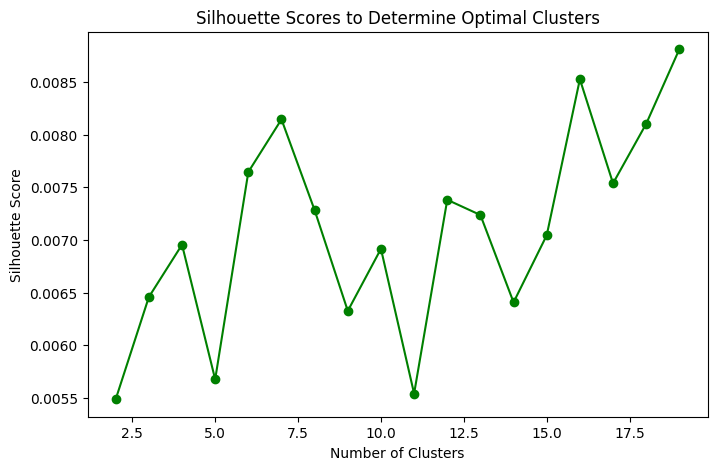

Optimal number of clusters: 19


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
sil_scores = []
X_tfidf = vectorizer.fit_transform(cleaned_reviews)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(X_tfidf, labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores to Determine Optimal Clusters')
plt.show()

# Find the optimal number of clusters
optimal_k = k_range[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters: {optimal_k}")


In [63]:
# Cluster with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Group comments by cluster
clustered_comments = {}
for i, cluster_id in enumerate(clusters):
    clustered_comments.setdefault(cluster_id, []).append(cleaned_reviews[i])

# Print clustered comments
for cluster_id, comment_group in clustered_comments.items():
    print(f"\nCluster {cluster_id}:\n", comment_group)



Cluster 16:
 ["The course teaches SQL quite well. But it doesn't teach and make practice about the connection to a database and use of sql magic. Hence, its very frustrating to understand the significance of '%sql' in a Final Assignment review. I think a lot of students are facing the same problem. Hence, it feels like- Final assignment is to check whether we can connect to the database, rather than checking our subject knowledge on SQL.", "Lots of errors. To this course's credit, there was a lot of effort providing practice work in the early material. For the more difficult tasks at the end, there was far less structured practice work. https://www.w3schools.com/sql/default.asp this link will come in extremely useful, as will supplementary YouTube videos..", 'Labs are always down and time out so you are unable to practice what you are learning.... Very frustrating!', 'Tools used like Database console and Jupyter notebook used also crashes repeatedly. Course just gives very brief intro

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [73]:
# Load Pegasus model and tokenizer
model_path = "/kaggle/working/best_t5pc_model"  # Your fine-tuned model directory
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)


# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate summary
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to GPU/CPU
    summary_ids = model.generate(
    **inputs,
    max_length=256,  # Limit summary length
    num_beams=8,  # Beam search for better summaries
    early_stopping=True,  # Stop once summary makes sense
    no_repeat_ngram_size=3,  # Prevent repeating phrases
    length_penalty= 1.5,  # Encourage concise summaries
    repetition_penalty=2.0  # Reduce excessive repetitions
)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary
clus_sum = ''
for cluster_id, comment_group in clustered_comments.items():
    clu_sum = generate_summary(comment_group)
    clus_sum += clu_sum
print(clus_sum)

OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 20.12 MiB is free. Process 3006 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 352.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)